# Computing the mean using `multiprocessing`

In this notebook, we compute the mean of an array of random numbers.  

Rather than import NumPy, we will use the `%pylab` magic command, which essentially is equivalent

    from numpy import *
    from scipy import *
    from matplotlib.pyplot import *
    
**Note:**  To use this notebook, you will need to install the Pandas package.  

    $ pip install pandas
    
or 

    $ sudo pip install pandas
    

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import multiprocessing as mp
import pandas

<hr style="border-style:solid;border-width:3px; border-color:coral"/hr>

## Computing the mean of an array of numbers

In [3]:
N = 2**28
x = random.rand(N)
print("Memory = {:.4f} (MB)".format(8*N/1024**2))

Memory = 2048.0000 (MB)


Write a function that computes the mean of the array of values using `np` processes.

In [4]:
def vector_sum(x,cpipe):    
    s = sum(x)
    cpipe.send(s)
    
def compute_mean(x,np):
    N = len(x)
    jobs = []
    pp = []
    for i in range(np):
        ppipe, cpipe = mp.Pipe(duplex=True)   # Duplex=True is default
        i1 = int(i*N/np)
        i2 = int((i+1)*N/np)
        
        job = mp.Process(target=vector_sum,args=(x[i1:i2],cpipe))
        pp.append(ppipe)
        jobs.append(job)
        
    for job in jobs:
        job.start()
    
    for job in jobs:
        job.join()

    s = 0
    for p in pp:
        s += p.recv()     
        
    return s/N    

### Verify results
Let's check that our parallel results are correct by comparing with the Numpy routine `mean`.  At the same time, we can time the results to see how the parallel compares to an optimized serial code. 

In [5]:
%time a1 = compute_mean(x,8)
print("a1 = {:24.16f}".format(a1))
print("")

%time a2 = mean(x)
print("a2 = {:24.16f}".format(a2))

CPU times: user 15.9 ms, sys: 42 ms, total: 57.8 ms
Wall time: 341 ms
a1 =       0.4999848681493988

CPU times: user 366 ms, sys: 2.41 ms, total: 369 ms
Wall time: 370 ms
a2 =       0.4999848681493975


<hr style="border-style:solid;border-width:3px; border-color:coral"/hr>

### Scalability : Speed-up  and strong scaling
Let's collect timing data for a range of processor counts so that we can see if we are getting good "scalability" and "speed-up". 

**Speed-up**

What is "speed-up"?  The speed-up $S_p$ on $p$ processors is the ratio of time on a single processor to the time on $p$ processors. 

\begin{equation*}
S_p = \frac{T_1}{T_p}
\end{equation*}

Perfect speed-up is $S_p = p$.  

**Strong Scaling**

Strong-scaling refers to how a parallel program behaves as it solves a fixed-size problem with an increasing number of processors.  Generally, as the number of processors increases, communication costs go up and more time is spent communicating between processes (transferring data in the present problem), the marginal effectiveness of adding more processes decreases.  
A parallel program is said to scale well (in the strong scaling sense) if the speed-up does not drop off dramatically as more processors are added to solve the problem.  Problems with no communication costs are expected to scale well (although not perfectly, since there is still a cost to even launching a process). 

A related concept is **weak scaling**, which we discuss later.

To read more about scaling, read Chapter 2, in "Introduction to High Performance Computing" (Victor Eijkhout, on the course GitHub site.)

In [6]:
# Use 'timeit' loop (see 'using_timeit' notebook.)
# Arguments to timeit : 
#  n : Number of inner loop repetitions
#  r : Number of outerloop repetitions
procs = 2**arange(0,6)
tdata = empty(procs.shape)
for i,np in enumerate(procs):
    tr = %timeit -n 1 -r 5 -q -o pass; compute_mean(x,np)
    tdata[i] = tr.best    # Choose the minimum value

### Store the timing data

Pandas is Python module that can be used to store data.  Using Pandas, we can present our data in a nice spreadsheet-type format, easily control the formatting, and as will see later, we can inspect, plot and analyze the data in a variety of interesting ways.

In [7]:
df = pandas.DataFrame({'Procs' : procs, 'Time' : tdata})

fstr = {'Procs' : "{:d}".format, 'Time' : "{:.2f}".format}
df.style.format(fstr)

,Procs,Time
0,1,1.23
1,2,0.69
2,4,0.37
3,8,0.26
4,16,0.28
5,32,0.31


### Plot strong scaling results
We will use Pylab commands (which look very much like Matlab commands) to plot the strong scaling results. 

Note that we can now access data in the Data Frame using names we gave the data.

<IPython.core.display.Javascript object>


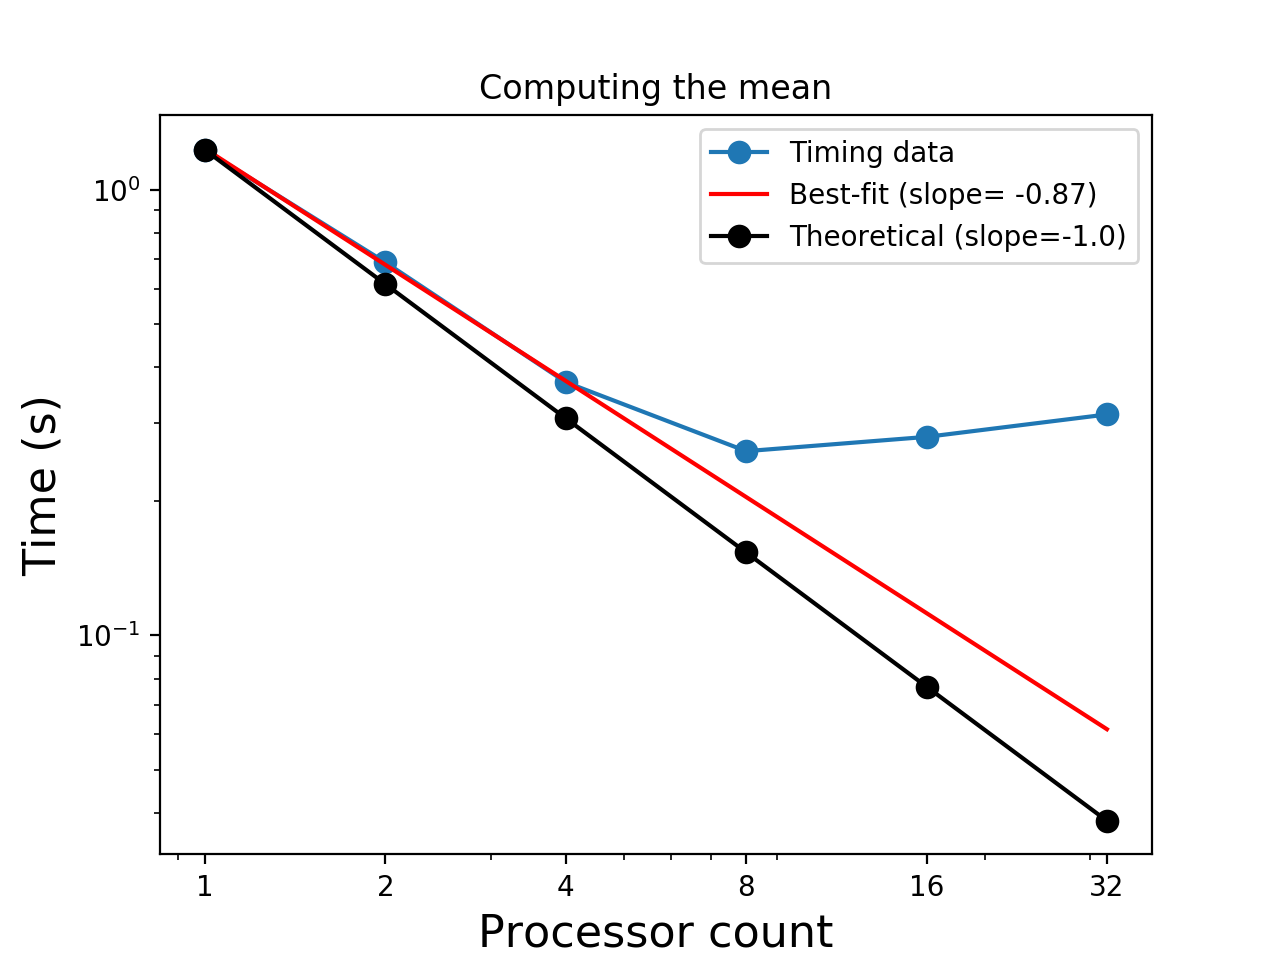

In [8]:
figure(1)
clf()

# Plot strong scaling results
loglog(df['Procs'],df['Time'],'.-',markersize=15,label='Timing data')

xlabel('Processor count',fontsize=16)
ylabel('Time (s)',fontsize=16)
title('Computing the mean');

### Best-fit line to data frame

We can estimate the slope of our data by computing the best fit line through the data.  We expect the data to fit the model 

\begin{equation*}
T_p = \frac{T_1}{p}
\end{equation*}

Taking the log of both sides of this model, we get

\begin{equation*}
\log(T_p) = -p + \log(T_1)
\end{equation*}

We fit the linear model

\begin{equation*}
\log(T_p) = c_0 p + c_1
\end{equation*}

to the data $(p,\log(T_p))$ using the `polyfit` routine.  If our routine scales well, the slope $c_0$  will be close to a theoretical slope $-1$.  The  coefficient $c_1$ should be close to $\log(T_1)$. 

As a practical matter, we only fit data through the first few points, since it clear that beyond about 4 processes, we do not get any benefit from additional processes.

In [9]:
figure(1)
t_strong = df['Time'].values

# Only fit the data to the first few data points.
proc_max = 4                   # Proc count that shows good scaling
imax = int(log2(proc_max))+1   # Index in proc array

c = polyfit(log(procs[:imax]),log(t_strong[:imax]),1)

# Print the slope of the best fit line in the legend (added below)
loglog(procs,exp(polyval(c,log(procs))),'r-',label='Best-fit (slope={:6.2f})'.format(c[0]))

To compare our timing data with ideal scaling, we plot the theoretical slope for comparison.   The theoretical dependence of time on processor count is given by 

\begin{equation*}
T_p = \frac{T_1}{p}
\end{equation*}

We can use this to get an idea about how well our function `compute_mean` scales.

In [10]:
figure(1)

# Theoretical line : T = T_0/procs
loglog(procs,t_strong[0]/procs,'k.-',markersize=15,label='Theoretical (slope=-1.0)')

Add a legend and fix the tick marks so we can easily see the processor counts

In [11]:
figure(1)
legend()

# Make nice tick marks
pstr = (['{:d}'.format(int(p)) for p in procs])
xticks(procs,pstr);

### Analysis

When this is run on a Mac with four cores, we see that we get nice speed-up on the first four cores.  At 8 cores, the scaling drops off slightly, since each core is using hyperthreading to simulate additional parallelism.   Beyond 8 cores, though, we see no benefit from additional cores.

<hr style="border-style:solid;border-width:3px; border-color:coral"/hr>

## Efficiency

Let's compute the efficiency and plot the results.  Efficiency is computed as follows.

**Efficiency**

A related measure is "efficiency".  This is the ratio of actual speed-up to expected speed-up. 

\begin{equation*}
E_p = \frac{S_p}{p}
\end{equation*}

Efficiency is often expressed as a percentage.  Perfect efficiency is 100%. 

To plot the efficiency, we first add extra columns representing speed-up and efficiency to our DataFrame.

In [12]:
df['Speed-up'] = df['Time'].values[0]/df['Time']
df['Efficiency'] = 100*df['Speed-up']/df['Procs']

fstr = {'Procs' : "{:d}".format, 'Time' : "{:.2f}".format,'Speed-up' : "{:.2f}".format,
       'Efficiency' : "{:.1f}".format}
df.style.format(fstr)

,Procs,Time,Speed-up,Efficiency
0,1,1.23,1.00,100.0
1,2,0.69,1.79,89.3
2,4,0.37,3.32,83.0
3,8,0.26,4.74,59.2
4,16,0.28,4.40,27.5
5,32,0.31,3.92,12.3


Then, we plot the efficiency.

<IPython.core.display.Javascript object>


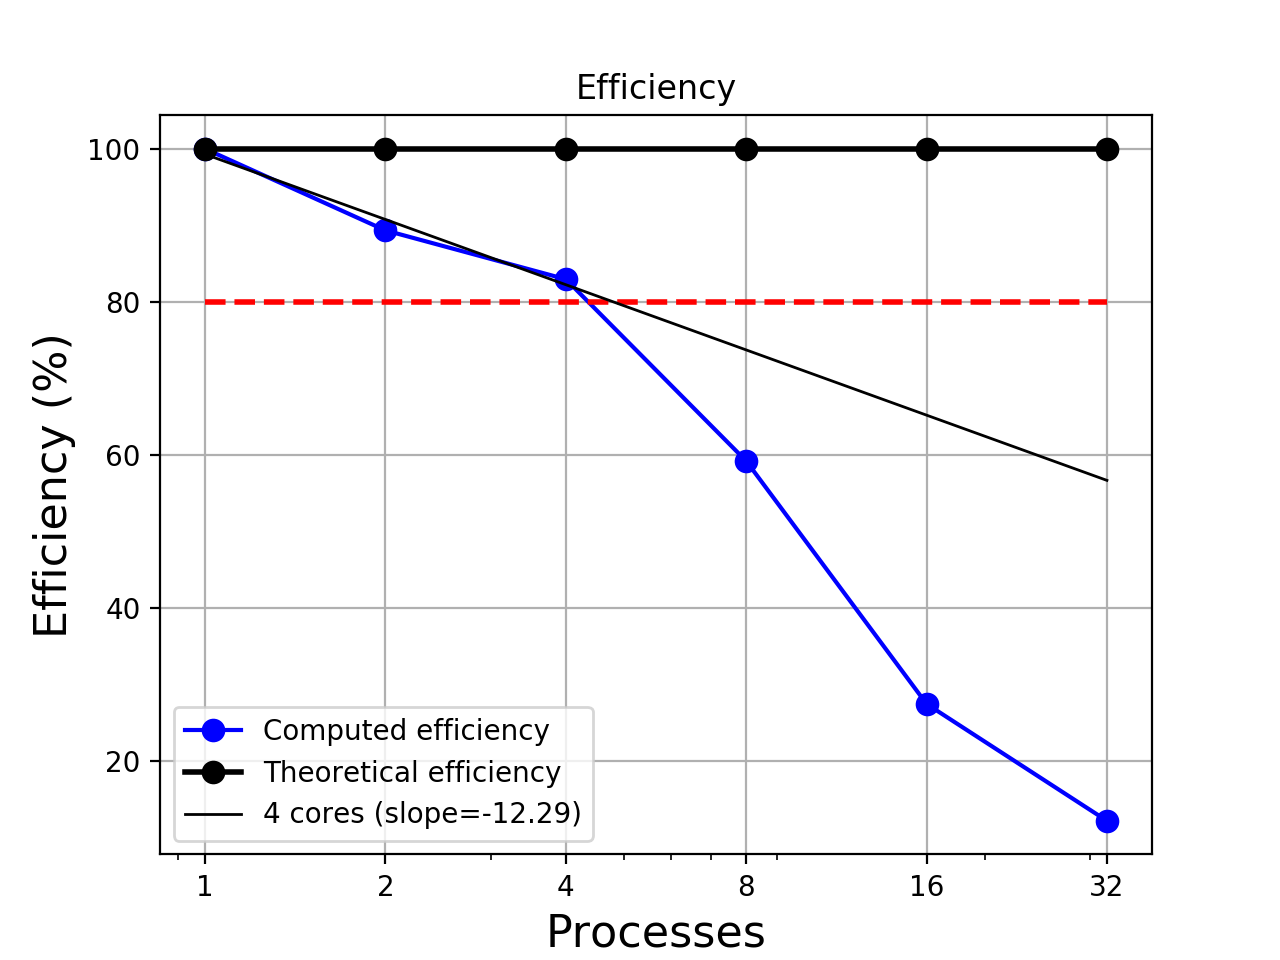

In [13]:
figure(2)
clf()
semilogx(df['Procs'],df['Efficiency'],'.-',color='b',markersize=15,label='Computed efficiency')

semilogx(df['Procs'],df['Procs']*0+ 100,'k.-',markersize=15,linewidth=2,label='Theoretical efficiency')

# Let's also add a line indicating "good" efficiency.
semilogx(df['Procs'],df['Procs']*0+ 80,'r--',markersize=15,linewidth=2)

# Add a best-fit line through first few cores.
t_eff = df['Efficiency'].values

# Fit line through first four cores
c = polyfit(log(procs[:imax]),t_eff[:imax],1)
semilogx(procs,polyval(c,log(procs)),'k-',label='4 cores (slope={:6.2f})'.format(c[0]),linewidth=1)


pstr = (['{:d}'.format(int(p)) for p in procs])
xticks(procs,pstr);

title('Efficiency')
xlabel('Processes',fontsize=16)
ylabel('Efficiency (%)',fontsize=16)

legend()
grid()

Efficiency for the first four cores is largely above 80%, which is considered quite good.
As we expect, the efficiency drops of dramatically after four cores.  To see this, we plot the best-fit line through results for the first four cores.